In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import gc

In [2]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int16)
    return df

In [4]:
sales_train = pd.read_csv('../input/sales_train.csv')
test = pd.read_csv('../input/test.csv').set_index('ID', drop=True)
items = pd.read_csv('../input/items.csv')
shops = pd.read_csv('../input/shops.csv')
item_categories = pd.read_csv('../input/item_categories.csv')

In [5]:
test['date_block_num'] = 34

# Outline
1. EDA
2. Preprocesssing
    - 2.1 Data Aggregation
    - 2.2 Add Category data and Item data and Shop data
3. FeatureEngineering
    - 3.1 item_price vs item_price_global
    - 3.2 Target Encoding
    - 3.3 Month Feature
    - 3.4 Item first salse 
    - 3.5 Take Lag 
    - 3.6 Past N month sales volume
4. Train Section
    - 4.1 Validation
    - 4.2 Prediction
5. Conclusion


*I am not an English speaker. I think there is a misspelling and incorrect grammer. I apologize in advance.*

## **1. EDA**
Exclude obvious outliers
- item_cnt_day > 500
- item_price > 50000

Sale volumne outliers: [ 8057 20949  9242 19437  3731 11373  9249  9248]


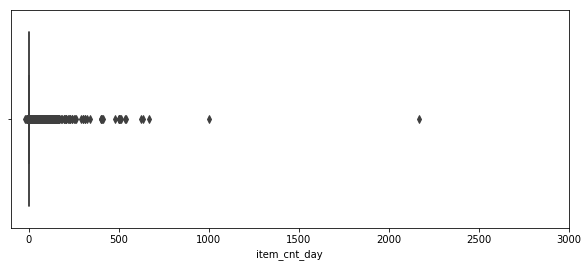

In [6]:
plt.figure(figsize=(10, 4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales_train['item_cnt_day'])
print('Sale volumne outliers:', sales_train['item_id'][sales_train['item_cnt_day']>500].unique())

Item price outliers: [11365  6066 13199]


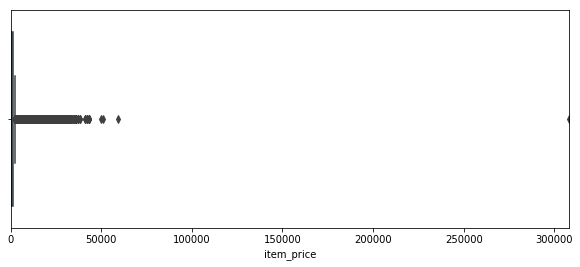

In [7]:
plt.figure(figsize=(10,4))
plt.xlim(sales_train['item_price'].min(), sales_train['item_price'].max())
sns.boxplot(x=sales_train['item_price'])
print('Item price outliers:', sales_train['item_id'][sales_train['item_price']>50000].unique())

In [8]:
sales_train = sales_train[sales_train.item_cnt_day < 500]
sales_train = sales_train[sales_train.item_price < 50000]

item_cnt_day has a negative value. This is the returned item, and keep it as a factor affecting the total value

In [9]:
sales_train[sales_train.item_cnt_day < 0].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0


Somel shops are considered to be duplicates of shop name. So merge one shop

In [10]:
shops[shops.shop_id.isin([0, 57, 1, 58, 10, 11])]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58


In [11]:
# Якутск Орджоникидзе, 56
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## **2. Preprocessing**

### 2.1. Data Aggregation
Aggregate sales_train on a monthly basis

- Target is clipped in the range(0, 20) (indicated Competition Infomation) , So clip the aggregate data in the same range
- Create a combination of all date_block_num and shop_id and item_id in sales_train for Traning data

In [12]:
sales_monthly = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
sales_monthly =sales_monthly.agg({'item_cnt_day':['sum']})
sales_monthly.columns = ['date_block_num', 'shop_id','item_id' ,'item_cnt_month']

In [13]:
sales_monthly['item_cnt_month'] = sales_monthly['item_cnt_month'].clip(0,20)

In [14]:
from itertools import product
empty_df = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_monthly[sales_monthly.date_block_num == i]
    empty_df.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    

empty_df = pd.DataFrame(np.vstack(empty_df), columns=cols)
empty_df['date_block_num'] = empty_df['date_block_num'].astype(np.int8)
empty_df['shop_id'] = empty_df['shop_id'].astype(np.int8)
empty_df['item_id'] = empty_df['item_id'].astype(np.int16)
empty_df.sort_values(cols,inplace=True)

In [15]:
sales_monthly = pd.merge(empty_df, sales_monthly, on=['date_block_num', 'shop_id', 'item_id'], how='left')

In [16]:
del empty_df
gc.collect()

42

### 2.2 Add Category data and Item data and Shop data

- Add category of city from shop_name with LabelEncoding
- item_categories has data with (Main type - sub_type). Split string and Create a new ID with LabelEncoding, If there is no sub type, replace it with Main type
- Find the global mean of item_price (average in all transactions group by item_id ) and use it as the standerd value of item_price. Replace the new item with the average of category id

In [17]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = pd.factorize(shops['city'])[0]
shops = shops[['shop_id','city_code']]

In [18]:
sales_monthly = pd.merge(sales_monthly, shops, on='shop_id', how='left')
test = pd.merge(test,shops, on='shop_id', how='left')

In [19]:
item_categories['split'] = item_categories.item_category_name.str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['sub_type'] = item_categories['split'].map(lambda x:x[1].strip() if len(x)>1 else x[0].strip())

In [20]:
item_categories['type'] = pd.factorize(item_categories['type'])[0]
item_categories['sub_type'] = pd.factorize(item_categories['sub_type'])[0]

In [21]:
item_categories = item_categories[['item_category_id', 'type', 'sub_type']]

In [22]:
item_prices = sales_train.groupby(['item_id'], as_index=False)['item_price'].agg('mean')

In [23]:
items = pd.merge(items, item_prices, on='item_id', how='left')

In [24]:
item_prices_cat = items[items.item_price.notnull()].groupby('item_category_id')['item_price'].agg('mean')

In [25]:
items.loc[items.item_price.isnull(),'item_price'] = items[items.item_price.isnull()]['item_category_id'].map(item_prices_cat)

In [26]:
items.drop(['item_name'], axis=1, inplace=True)

In [27]:
items = pd.merge(items, item_categories, on='item_category_id', how='left')

In [28]:
items.head()

,item_id,item_category_id,item_price,type,sub_type
0,0,40,58.0,11,22
1,1,76,4490.0,15,57
2,2,40,58.0,11,22
3,3,40,79.0,11,22
4,4,40,58.0,11,22


In [29]:
sales_monthly = pd.merge(sales_monthly, items, on=['item_id'], how='left')
test = pd.merge(test, items, on=['item_id'], how='left')

## **3 Feature Engineering**

### 3.1 item_price vs item_price_global
Add the ratio between the standard value of item_price and the actual sales price. I want to express discounts item price at shop

In [30]:
sales_monthly.rename(columns={'item_price':'item_price_global'}, inplace=True)
test.rename(columns={'item_price':'item_price_global'}, inplace=True)

In [31]:
shop_item_price = sales_train.groupby(['shop_id', 'item_id'], as_index=False)['item_price'].mean()

In [32]:
sales_monthly = pd.merge(sales_monthly, shop_item_price, on=['shop_id', 'item_id'], how='left')

In [33]:
sales_monthly['shop_price_vs_global_price'] = sales_monthly['item_price'] / sales_monthly['item_price_global']

In [34]:
sales_monthly.drop('item_price', axis=1, inplace=True)

### 3.2 Target Encoding
- Calculate the average of various combinations of targets. It essentially mean encording . If you add date_block_num to the group you do not have to worry about leak (you can not see future data)
- Mean Encoding of item_id and shop_id was done with 5-fold, but it the score did not improve, so I didn't add that feature. The snippet is shown below
```python
 for trn_idx, val_idx in kfold.split(sales_monthly):
        trn, val = sales_monthly.iloc[trn_idx], sales_monthly.iloc[val_idx]
        item_id_target_enc = trn.groupby('item_id')['item_cnt_month'].mean()
        val['item_id_target_enc'] = val['item_id'].map(item_id_target_enc)
        sales_monthly.loc[val_idx, 'item_id_target_enc'] = val['item_id_target_enc']
    
 sales_monthly['item_id_target_enc'].fillna(0, inplace=True) 
```

In [35]:
sales_monthly['date_item_target_enc'] =\
sales_monthly.groupby(['date_block_num','item_id'], as_index=False)['item_cnt_month'].transform('mean').astype(np.float16)

In [36]:
sales_monthly['date_target_enc'] =\
sales_monthly.groupby(['date_block_num'], as_index=False)['item_cnt_month'].transform('mean').astype(np.float16)

In [37]:
sales_monthly['date_shop_target_enc'] =\
sales_monthly.groupby(['date_block_num','shop_id'], as_index=False)['item_cnt_month'].transform('mean').astype(np.float16)

In [38]:
sales_monthly['date_cat_target_enc'] =\
sales_monthly.groupby(['date_block_num','item_category_id'], as_index=False)['item_cnt_month'].transform('mean').astype(np.float16)

In [39]:
sales_monthly['date_shop_cat_target_enc'] =\
sales_monthly.groupby(['date_block_num','shop_id','item_category_id'], as_index=False)['item_cnt_month'].transform('mean').astype(np.float16)

In [40]:
group = sales_monthly.groupby(['date_block_num','item_id','city_code'], as_index=False)['item_cnt_month'].agg('mean')
group.rename(columns={'item_cnt_month':'date_item_city_target_enc'}, inplace=True)

In [41]:
sales_monthly = pd.merge(sales_monthly, group, on=['date_block_num','item_id','city_code'], how='left')

### 3.3 Month Feature
It is processing concerning the feature of the month
- Convert date_block_num to month
- **Month has periodicity. But in 1-12 the model can not capture its circularity. Therefore we add the function to place month on the circumference.**
- Add days. For example, February has fewer days than other months. The number of sales should also drop.

In [42]:
date_block_num_to_month = {0: 1,1: 2,2: 3,3: 4,4: 5,5: 6,6: 7,
 7: 8,8: 9,9: 10,10: 11,11: 12,12: 1,
 13: 2,14: 3,15: 4,16: 5,17: 6,18: 7,19: 8,20: 9,
 21: 10,22: 11,23: 12,24: 1,25: 2,26: 3,27: 4,
 28: 5,29: 6,30: 7,31: 8,32: 9,33: 10,34: 11}

In [43]:
sales_monthly['month'] = sales_monthly['date_block_num'].map(date_block_num_to_month)
test['month'] = sales_monthly['date_block_num'].map(date_block_num_to_month)

In [44]:
sales_monthly['month_sin'] = np.sin(2 * np.pi * sales_monthly.month / 12.0)
test['month_sin'] = np.sin(2 * np.pi * test.month / 12.0)

In [45]:
sales_monthly['month_cos'] = np.cos(2 * np.pi * sales_monthly.month / 12.0)
test['month_cos'] = np.cos(2 * np.pi * test.month / 12.0)

In [46]:
month_days = {1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}

In [47]:
sales_monthly['days'] = sales_monthly['month'].map(month_days)
test['days'] = test['month'].map(month_days)

Concat test set

In [48]:
sales_monthly = pd.concat([sales_monthly, test], ignore_index=True, sort=False, keys=cols)

In [49]:
sales_monthly.tail()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,item_price_global,type,sub_type,shop_price_vs_global_price,date_item_target_enc,date_target_enc,date_shop_target_enc,date_cat_target_enc,date_shop_cat_target_enc,date_item_city_target_enc,month,month_sin,month_cos,days
11127951,34,45,18454,NaN,21,55,188.681084,13,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.5,0.866025,31
11127952,34,45,16188,NaN,21,64,1256.975000,14,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.5,0.866025,31
11127953,34,45,15757,NaN,21,55,198.113208,13,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.5,0.866025,31
11127954,34,45,19648,NaN,21,40,98.096296,11,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.5,0.866025,31
11127955,34,45,969,NaN,21,37,502.297061,11,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.5,0.866025,31


### 3.4 Take Lag 
Since it is necessary to predict the data of the future, I shift the function of the past and let the model learn.
- All features related to actual sales take lag. Except for target, I drop the original feature 

In [50]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in tqdm(lags):
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id',col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        
    return df

In [51]:
sales_monthly = lag_feature(sales_monthly, [1, 2, 3, 6, 12], 'item_cnt_month')

100%|██████████| 5/5 [00:53<00:00, 10.98s/it]


In [52]:
sales_monthly = lag_feature(sales_monthly, [1, 2, 3, 6, 12], 'shop_price_vs_global_price')
sales_monthly.drop('shop_price_vs_global_price', axis=1, inplace=True)

100%|██████████| 5/5 [00:57<00:00, 11.80s/it]


In [53]:
sales_monthly = lag_feature(sales_monthly, [1, 2, 3, 6, 12], 'date_item_target_enc')
sales_monthly.drop('date_item_target_enc', axis=1, inplace=True)

100%|██████████| 5/5 [00:56<00:00, 11.58s/it]


In [54]:
sales_monthly = lag_feature(sales_monthly, [1, 2, 3, 6, 12], 'date_shop_target_enc')
sales_monthly.drop('date_shop_target_enc', axis=1, inplace=True)

100%|██████████| 5/5 [00:59<00:00, 12.34s/it]


In [55]:
sales_monthly = lag_feature(sales_monthly, [1, 2, 3, 6, 12], 'date_cat_target_enc')
sales_monthly.drop('date_cat_target_enc', axis=1, inplace=True)

100%|██████████| 5/5 [01:01<00:00, 12.67s/it]


In [56]:
sales_monthly = lag_feature(sales_monthly, [1, 2, 3, 6, 12], 'date_shop_cat_target_enc')
sales_monthly.drop('date_shop_cat_target_enc', axis=1, inplace=True)

100%|██████████| 5/5 [01:02<00:00, 12.90s/it]


In [57]:
sales_monthly = lag_feature(sales_monthly, [1, 2, 3, 6, 12], 'date_target_enc')
sales_monthly.drop('date_target_enc', axis=1, inplace=True)

100%|██████████| 5/5 [01:05<00:00, 13.45s/it]


In [58]:
sales_monthly = lag_feature(sales_monthly, [1, 2, 3, 6, 12], 'date_item_city_target_enc')
sales_monthly.drop('date_item_city_target_enc', axis=1, inplace=True)

100%|██████████| 5/5 [01:05<00:00, 13.37s/it]


###  3.3 Item first salse 
New products should sell well. Add date_block_month as feature sold first item month

In [59]:
sales_monthly['item_first_sale'] = sales_monthly.date_block_num - \
sales_monthly.groupby('item_id')['date_block_num'].transform('min')

In [60]:
sales_monthly['shop_item_first_sale'] = sales_monthly.date_block_num - \
sales_monthly.groupby(['shop_id','item_id'])['date_block_num'].transform('min')

Since I took a lag, I can not use the data of 12 months ago. We will use data from the last 12 months

In [61]:
train_test_set = sales_monthly[sales_monthly.date_block_num > 11].copy()

### 3.5 Past N month sales volume
We will add the total sales volume for the most recent N months to the feature. Shops that have opened recently should have relatively higher sales volumes than other shops

In [62]:
for past in tqdm([1, 2, 3, 6, 12]):
    df = pd.DataFrame()
    for start_date in train_test_set.date_block_num.unique():
        group = sales_monthly[sales_monthly.date_block_num.isin(list(range(start_date-past, start_date)))]
        group = group.groupby(['shop_id','item_id'], as_index=False).item_cnt_month.sum()
        group.rename(columns={'item_cnt_month':'item_cnt_{}_month_past_sum'.format(past)}, inplace=True)
        group['date_block_num'] = start_date

        df = pd.concat([df, group])

    train_test_set = pd.merge(train_test_set, df, on=['date_block_num','shop_id','item_id'], how='left')

100%|██████████| 5/5 [03:13<00:00, 43.67s/it]


*******
All the functions are added.  
After filling NaN with 0, save the processed data table as a checkpoint. Downtype dtype for memory

In [63]:
train_test_set.fillna(0, inplace=True)

In [64]:
train_test_set.tail()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,item_price_global,type,sub_type,month,month_sin,month_cos,days,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,shop_price_vs_global_price_lag_1,shop_price_vs_global_price_lag_2,shop_price_vs_global_price_lag_3,shop_price_vs_global_price_lag_6,shop_price_vs_global_price_lag_12,date_item_target_enc_lag_1,date_item_target_enc_lag_2,date_item_target_enc_lag_3,date_item_target_enc_lag_6,date_item_target_enc_lag_12,date_shop_target_enc_lag_1,date_shop_target_enc_lag_2,date_shop_target_enc_lag_3,date_shop_target_enc_lag_6,date_shop_target_enc_lag_12,date_cat_target_enc_lag_1,date_cat_target_enc_lag_2,date_cat_target_enc_lag_3,date_cat_target_enc_lag_6,date_cat_target_enc_lag_12,date_shop_cat_target_enc_lag_1,date_shop_cat_target_enc_lag_2,date_shop_cat_target_enc_lag_3,date_shop_cat_target_enc_lag_6,date_shop_cat_target_enc_lag_12,date_target_enc_lag_1,date_target_enc_lag_2,date_target_enc_lag_3,date_target_enc_lag_6,date_target_enc_lag_12,date_item_city_target_enc_lag_1,date_item_city_target_enc_lag_2,date_item_city_target_enc_lag_3,date_item_city_target_enc_lag_6,date_item_city_target_enc_lag_12,item_first_sale,shop_item_first_sale,item_cnt_1_month_past_sum,item_cnt_2_month_past_sum,item_cnt_3_month_past_sum,item_cnt_6_month_past_sum,item_cnt_12_month_past_sum
6639241,34,45,18454,0.0,21,55,188.681084,13,36,1,0.5,0.866025,31,1.0,0.0,0.0,0.0,0.0,0.995801,0.995801,0.995801,0.995801,0.000000,1.0,1.00,1.000000,1.299805,0.000000,1.47168,1.597656,1.40625,1.501953,0.000000,1.349609,1.247070,1.283203,1.339844,0.000000,1.197266,1.116211,1.166992,1.290039,0.000000,1.952148,1.943359,1.844727,1.87207,0.000000,1.0,0.0,0.0,0.0,0.0,11,11,1.0,1.0,1.0,1.0,9.0
6639242,34,45,16188,0.0,21,64,1256.975000,14,45,1,0.5,0.866025,31,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.00,0.000000,0.000000,0.000000,1.47168,1.597656,0.00000,0.000000,0.000000,1.330078,1.277344,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.952148,1.943359,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,2,2,0.0,0.0,0.0,0.0,0.0
6639243,34,45,15757,0.0,21,55,198.113208,13,36,1,0.5,0.866025,31,0.0,0.0,0.0,0.0,0.0,1.004476,1.004476,1.004476,1.004476,1.004476,1.0,1.00,1.000000,1.222656,1.125000,1.47168,1.597656,1.40625,1.501953,1.851562,1.349609,1.247070,1.283203,1.339844,1.445312,1.197266,1.116211,1.166992,1.290039,1.347656,1.952148,1.943359,1.844727,1.87207,2.150391,0.0,1.0,0.0,0.0,0.0,34,34,0.0,0.0,0.0,0.0,2.0
6639244,34,45,19648,0.0,21,40,98.096296,11,22,1,0.5,0.866025,31,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.00,1.166992,1.000000,0.000000,1.47168,1.597656,1.40625,1.501953,0.000000,1.617188,1.552734,1.606445,1.711914,0.000000,1.269531,1.208008,1.309570,1.229492,0.000000,1.952148,1.943359,1.844727,1.87207,0.000000,0.0,0.0,0.0,0.0,0.0,11,11,0.0,0.0,0.0,0.0,0.0
6639245,34,45,969,0.0,21,37,502.297061,11,21,1,0.5,0.866025,31,0.0,0.0,0.0,0.0,0.0,1.092979,1.092979,1.092979,1.092979,1.092979,1.0,1.25,1.000000,1.000000,1.200195,1.47168,1.597656,1.40625,1.501953,1.851562,1.662109,1.498047,1.482422,1.462891,1.522461,1.154297,1.150391,1.133789,1.215820,1.149414,1.952148,1.943359,1.844727,1.87207,2.150391,1.0,0.0,0.0,0.0,0.0,17,17,0.0,0.0,0.0,0.0,0.0


In [65]:
train_test_set.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'item_price_global', 'type', 'sub_type', 'month',
       'month_sin', 'month_cos', 'days', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'shop_price_vs_global_price_lag_1',
       'shop_price_vs_global_price_lag_2', 'shop_price_vs_global_price_lag_3',
       'shop_price_vs_global_price_lag_6', 'shop_price_vs_global_price_lag_12',
       'date_item_target_enc_lag_1', 'date_item_target_enc_lag_2',
       'date_item_target_enc_lag_3', 'date_item_target_enc_lag_6',
       'date_item_target_enc_lag_12', 'date_shop_target_enc_lag_1',
       'date_shop_target_enc_lag_2', 'date_shop_target_enc_lag_3',
       'date_shop_target_enc_lag_6', 'date_shop_target_enc_lag_12',
       'date_cat_target_enc_lag_1', 'date_cat_target_enc_lag_2',
       'date_cat_target_enc_lag_3', 'date_cat_target_enc_lag_6',
       

In [66]:
train_test_set = downcast_dtypes(train_test_set)

In [67]:
import pickle
train_test_set.to_pickle('train_test_set.pkl')

In [68]:
del train_test_set
del shops
del items
del item_categories
del sales_train
del item_prices
del item_prices_cat
del sales_monthly
del group

gc.collect()

85

In [69]:
train_test_set = pd.read_pickle('train_test_set.pkl')

## 4. Train Section
I referred to the public kernel hyperparameter. I adjusted some parts manually.

- Validation Strategy : It is time-series data, random train_test_split can not be used. Therefore, one month before prediction use for validation set. I mean
    - train set : date_block_num < 32
    - valid_set :  date_block_num == 33
    - test_set : date_block_num == 34
    
 
- Training
     - **Model 1 LightGBM** : literally very light, so Model can train with all the features.
     - **Molde 2 LinerRegression** : I hope to capture the linear relationship that Tree Base Molde can not catch.
     - **Model 3 XGboost** : XGboost use very much memory, we can not use all features. We will use Top 30 features used in Model 1. This is thought to bring a kind of diversity


- Brending : 
I did not have enough time to do the stacking. Therefore, heuristically weigh each prediction and make it the final result. 

In [70]:
train_set = train_test_set.query('date_block_num <= 32').copy()
valid_set = train_test_set.query('date_block_num == 33').copy()
test_set = train_test_set.query('date_block_num == 34').copy()

In [71]:
print('train_set', train_set.shape)
print('valid_set', valid_set.shape)
print('test_set',test_set.shape)

train_set (6186874, 60)
valid_set (238172, 60)
test_set (214200, 60)


In [72]:
X_train = train_set.drop('item_cnt_month', axis=1)
y_train = train_set['item_cnt_month'].values
X_valid = valid_set.drop('item_cnt_month', axis=1)
y_valid = valid_set['item_cnt_month'].values
X_test = test_set.drop('item_cnt_month', axis=1)

In [73]:
del train_test_set
gc.collect()

7

******
LightGBM

In [74]:
train_data = lgb.Dataset(X_train, label=y_train)
eval_data = lgb.Dataset(X_valid, label=y_valid, reference= train_data)

In [75]:
lgb_params = {
    'max_dapth':8,
    'min_data_in_leaf':300,
    'num_leaves': 2**7,
    'feature_fraction':0.7,
    'bagging_fraction':0.7,
    'learning_rate': 0.1,
    'objective': 'rmse',
}

In [76]:
lgb_reg = lgb.train(
    params = lgb_params,
    train_set=train_data,
    valid_sets=eval_data,
    early_stopping_rounds=10,
    num_boost_round=100,
    verbose_eval=5,
)

Training until validation scores don't improve for 10 rounds.
[5]	valid_0's rmse: 0.994584
[10]	valid_0's rmse: 0.939876
[15]	valid_0's rmse: 0.92273
[20]	valid_0's rmse: 0.913371
[25]	valid_0's rmse: 0.911036
[30]	valid_0's rmse: 0.909449
[35]	valid_0's rmse: 0.907855
[40]	valid_0's rmse: 0.90749
Early stopping, best iteration is:
[32]	valid_0's rmse: 0.906849


In [77]:
importances = pd.DataFrame(lgb_reg.feature_importance(), index=X_train.columns, columns=['importance'])
importances = importances.sort_values('importance', ascending=False)

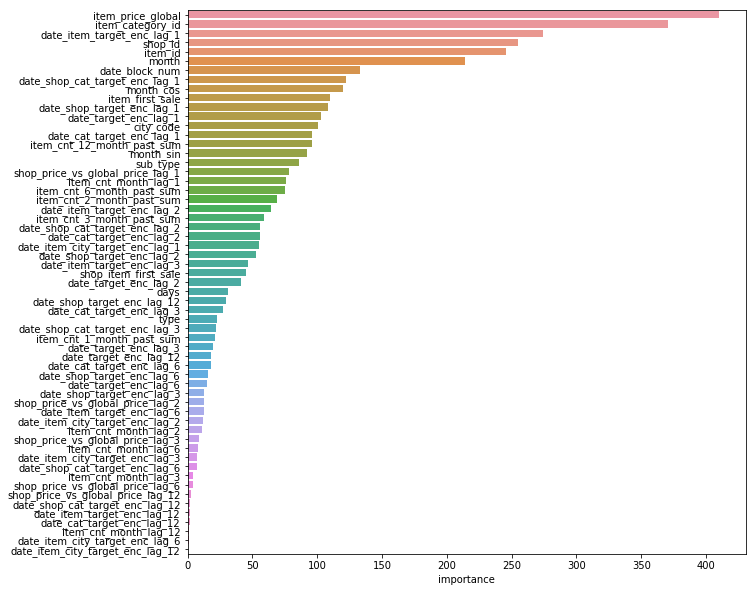

In [78]:
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y=importances.index, data=importances)

In [79]:
y_pred_lgb = lgb_reg.predict(X_test)

In [80]:
pickle.dump(lgb_reg, open('lgb_reg.pickle', 'wb'))

******
LinerModel

In [81]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [82]:
y_pred_lr = lr_reg.predict(X_test)
y_pred_lr_val = lr_reg.predict(X_valid)

In [83]:
print(rmse(y_valid, y_pred_lr_val))

0.96693116


******
XGBoost

In [84]:
useful_col_top30 = importances.index.tolist()[:30]

In [85]:
X_train = X_train[useful_col_top30]
X_valid = X_valid[useful_col_top30]
X_test = X_test[useful_col_top30]

In [86]:
xgb_reg = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3
)

xgb_reg.fit(
    X_train,y_train,
    eval_metric='rmse',
    eval_set=[(X_train, y_train),(X_valid, y_valid)],
    verbose=1,
    early_stopping_rounds=10
)

[05:04:43] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.1501	validation_1-rmse:1.11631
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10195	validation_1-rmse:1.08082
[2]	validation_0-rmse:1.0634	validation_1-rmse:1.05312
[3]	validation_0-rmse:1.02796	validation_1-rmse:1.02796
[4]	validation_0-rmse:0.99771	validation_1-rmse:1.00574
[5]	validation_0-rmse:0.972297	validation_1-rmse:0.988106
[6]	validation_0-rmse:0.950703	validation_1-rmse:0.973526
[7]	validation_0-rmse:0.932237	validation_1-rmse:0.961183
[8]	validation_0-rmse:0.91773	validation_1-rmse:0.952344
[9]	validation_0-rmse:0.905339	validation_1-rmse:0.945115
[10]	validation_0-rmse:0.89425	validation_1-rmse:0.939533
[11]	validation_0-rmse:0.88515	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=300, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [87]:
y_pred_xgb = xgb_reg.predict(X_test)

In [88]:
y_pred = (y_pred_xgb * 0.45  + y_pred_lgb * 0.45 + y_pred_lr * 0.1)

In [89]:
print(y_pred.mean())
print(y_pred.max())

0.23895656470351276
19.387081642401398


In [90]:
submission = pd.DataFrame({
    'ID':test.index,
    'item_cnt_month':y_pred.clip(0, 20)
})

In [91]:
submission.head()

,ID,item_cnt_month
0,0,0.513589
1,1,0.255622
2,2,0.726020
3,3,0.223770
4,4,3.299327


In [92]:
submission.to_csv('submission.csv', index=False)

# 5. Conclusion
LightGBM single model has score 0.97387. Blending model has score 0.94676. I got an improvement of 0.27 with Blending.  
I added various feature quantities, but I could not beat the best public Kenerl (Public socre 0.908...)  


**After all I think FeatureEngineering is most important!!!!**

Thank you for reading to the end.
The final task was very challenging, but I had fun.
Thank you for your evaluation in order to pass the assignment